In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import pickle
from sklearn.metrics import r2_score
from validation.metrics import OME, MSE, get_CV_error
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from MODELS.ViscNN import load_models, create_ViscNN_concat, predict_all_cv, ViscNN_concat_HP
#from validation.tests import custom_train_test_split, get_Mw_samples, crossval_NN, Mw_test, evaluate_model, crossval_compare, get_shear_samples, shear_test, small_shear_test, assign_sample_ids

/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-01-19 15:46:02.694097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 15:46:03.391971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30985 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:da:00.0, compute capability: 7.0


In [ ]:
with open('Data/ann_LC.pickle', 'wb') as handle:
    pickle.dump(ANN_OME, handle)

with open('Data/gpr_LC.pickle', 'wb') as handle:
    pickle.dump(GPR_OME, handle)

In [22]:
os.listdir('./MODELS')

['2022-11-24_LC0_aug_split_test_0.9_full',
 '__pycache__',
 '2022-11-25_LC0_aug_split_test_0.4_full',
 'hypernetwork.py',
 '2022-11-28_LC0_aug_split_test_0.2_full',
 '2022-11-28_LC6_aug_split_test_0.1_full',
 '2022-11-24_LC0_aug_split_test_0.5_full',
 '2022-11-28_LC9_aug_split_test_0.1_full',
 '2022-11-27_gpr_test',
 '2022-11-27_LC2_aug_split_test_0.1_full',
 '2022-11-24_LC0_aug_split_test_0.8_full',
 '2022-10-05_full_aug_mod',
 '2022-11-21_polysplit1_aug_mod',
 '2022-11-28_LC8_aug_split_test_0.1_full',
 '2022-11-25_LC0_aug_split_test_0.2_full',
 '2022-11-23_full_aug_mod',
 '2022-11-30_LC1_aug_split_test_0.4_full',
 '2022-11-22_full_aug_mod',
 '2022-11-25_LC0_aug_split_test_0.3_full',
 '2022-11-25_LC0_aug_split_test_0.1_full',
 '2022-11-24_full_aug_mod',
 '2022-11-25_LC1_aug_split_test_0.9_full',
 '2022-11-28_LC5_aug_split_test_0.1_full',
 '2022-11-24_LC0_aug_split_test_0.7_full',
 '2022-11-28_LC4_aug_split_test_0.1_full',
 '2022-11-30_LC1_aug_split_test_0.9_full',
 '2022-11-24_LC0_aug

# Read HypNet Results

In [37]:
GPR_OME = {'test':{'avg':[], 'std': []}, 'train':{'avg':[], 'std': []}}
ANN_OME = {'test':{'avg':[], 'std': []}, 'train':{'avg':[], 'std': []}}
HypNet_OME = {'test':{'avg':[], 'std': []}, 'train':{'avg':[], 'std': []}}
GPR_R2 = {'test':{'avg':[], 'std': []}, 'train':{'avg':[], 'std': []}}
ANN_R2 = {'test':{'avg':[], 'std': []}, 'train':{'avg':[], 'std': []}}
HypNet_R2 = {'test':{'avg':[], 'std': []}, 'train':{'avg':[], 'std': []}}
models_list = os.listdir('./MODELS')
test_type = None
for test_size in [0.9, 0.7, 0.5, 0.4, 0.3, 0.2, 0.1]:
    GPR_err = {'test': [], 'train':[]}
    ANN_err = {'test': [], 'train':[]}
    HypNet_err = {'test': [], 'train':[]}
    GPR_trend = {'test': [], 'train':[]}
    ANN_trend = {'test': [], 'train':[]}
    HypNet_trend = {'test': [], 'train':[]}
    for mod_num in [0,1,2,3,4,5,6,7,8,9,10,11]:
        #try: 
        
        trial_list = [m for m in models_list if f'LC{mod_num}_' in m and f'_{test_size}' in m]
        if len(trial_list) == 0:
            continue
        test_type = trial_list[0]
        try:
            train_results = pd.read_pickle(f'MODELS/{test_type}/train_evals.pkl')
            test_results = pd.read_pickle(f'MODELS/{test_type}/test_evals.pkl')
        except FileNotFoundError:
            if len(trial_list) > 1:
                test_type = trial_list[1]
                train_results = pd.read_pickle(f'MODELS/{test_type}/train_evals.pkl')
                test_results = pd.read_pickle(f'MODELS/{test_type}/test_evals.pkl')
            else:
                continue
        print(mod_num, test_size)

        HypNet_err['train'].append(OME(np.array(train_results['Melt_Viscosity']), np.array(train_results['HyperNet_Pred'])))
        HypNet_err['test'].append(OME(np.array(test_results['Melt_Viscosity']), np.array(test_results['HyperNet_Pred'])))
        ANN_err['train'].append(OME(np.array(train_results['Melt_Viscosity']), np.array(train_results['ANN_Pred'])))
        ANN_err['test'].append(OME(np.array(test_results['Melt_Viscosity']), np.array(test_results['ANN_Pred'])))
        HypNet_trend['train'].append(r2_score(np.array(train_results['Melt_Viscosity']), np.array(train_results['HyperNet_Pred'])))
        HypNet_trend['test'].append(r2_score(np.array(test_results['Melt_Viscosity']), np.array(test_results['HyperNet_Pred'])))
        ANN_trend['train'].append(r2_score(np.array(train_results['Melt_Viscosity']), np.array(train_results['ANN_Pred'])))
        ANN_trend['test'].append(r2_score(np.array(test_results['Melt_Viscosity']), np.array(test_results['ANN_Pred'])))
        
        
        try:    
            GPR_err['train'].append(OME(np.array(train_results['Melt_Viscosity']), np.array(train_results['GPR_Pred'])))
            GPR_err['test'].append(OME(np.array(test_results['Melt_Viscosity']), np.array(test_results['GPR_Pred'])))
            GPR_trend['train'].append(r2_score(np.array(train_results['Melt_Viscosity']), np.array(train_results['GPR_Pred'])))
            GPR_trend['test'].append(r2_score(np.array(test_results['Melt_Viscosity']), np.array(test_results['GPR_Pred'])))
        except:
            print('GPR did not have test or train data.')

    if test_size == 0.2:
        print('0.2 test pim error: ', [n.numpy() for n in HypNet_err['test']])
    HypNet_err['test'] = [n for n in HypNet_err['test'] if n < float('+inf')]
    HypNet_err['train'] = [n for n in HypNet_err['train'] if n < float('+inf')]
    
    print(test_size)
    ANN_OME['test']['avg'].append(np.mean(ANN_err['test']))
    ANN_OME['test']['std'].append(np.std(ANN_err['test']))
    ANN_OME['train']['avg'].append(np.mean(ANN_err['train']))
    ANN_OME['train']['std'].append(np.std(ANN_err['train']))
    GPR_OME['test']['avg'].append(np.mean(GPR_err['test']))
    GPR_OME['test']['std'].append(np.std(GPR_err['test']))
    GPR_OME['train']['avg'].append(np.mean(GPR_err['train']))
    GPR_OME['train']['std'].append(np.std(GPR_err['train']))
    HypNet_OME['test']['avg'].append(np.mean(HypNet_err['test']))
    HypNet_OME['test']['std'].append(np.std(HypNet_err['test']))
    HypNet_OME['train']['avg'].append(np.mean(HypNet_err['train']))
    HypNet_OME['train']['std'].append(np.std(HypNet_err['train']))
    #R2 scords
    ANN_R2['test']['avg'].append(np.mean(ANN_trend['test']))
    ANN_R2['test']['std'].append(np.std(ANN_trend['test']))
    ANN_R2['train']['avg'].append(np.mean(ANN_trend['train']))
    ANN_R2['train']['std'].append(np.std(ANN_trend['train']))
    GPR_R2['test']['avg'].append(np.mean(GPR_trend['test']))
    GPR_R2['test']['std'].append(np.std(GPR_trend['test']))
    GPR_R2['train']['avg'].append(np.mean(GPR_trend['train']))
    GPR_R2['train']['std'].append(np.std(GPR_trend['train']))
    HypNet_R2['test']['avg'].append(np.mean(HypNet_trend['test']))
    HypNet_R2['test']['std'].append(np.std(HypNet_trend['test']))
    HypNet_R2['train']['avg'].append(np.mean(HypNet_trend['train']))
    HypNet_R2['train']['std'].append(np.std(HypNet_trend['train']))

0 0.9
1 0.9
2 0.9
3 0.9
4 0.9
5 0.9
6 0.9
7 0.9
8 0.9
9 0.9
10 0.9
11 0.9
0.9
0 0.7
1 0.7
2 0.7
3 0.7
4 0.7
5 0.7
6 0.7
7 0.7
8 0.7
9 0.7
10 0.7
11 0.7
0.7
0 0.5
1 0.5
2 0.5
3 0.5
4 0.5
5 0.5
6 0.5
7 0.5
8 0.5
9 0.5
10 0.5
11 0.5
0.5
0 0.4
1 0.4
2 0.4
3 0.4
4 0.4
5 0.4
6 0.4
7 0.4
8 0.4
9 0.4
10 0.4
11 0.4
0.4
0 0.3
1 0.3
2 0.3
3 0.3
4 0.3
5 0.3
6 0.3
7 0.3
8 0.3
9 0.3
10 0.3
11 0.3
0.3
0 0.2
1 0.2
2 0.2
3 0.2
4 0.2
5 0.2
6 0.2
7 0.2
8 0.2
9 0.2
10 0.2
11 0.2
0.2 test pim error:  [1.2237493, 1.4995767, 0.7978908, 2.8557136, 2.135605, 1.7309761, 2.6441755, 1.5074837]
0.2
0 0.1
1 0.1
2 0.1
3 0.1
4 0.1
5 0.1
6 0.1
7 0.1
8 0.1
9 0.1
10 0.1
11 0.1
0.1


In [33]:
HypNet_OME

{'test': {'avg': [1.3272239,
   1.2369854,
   1.2548527,
   1.3147051,
   1.2024604,
   1.7993963,
   1.1048652],
  'std': [0.10998905,
   0.14866954,
   0.26171064,
   0.26033548,
   0.31879932,
   0.65733016,
   0.2561554]},
 'train': {'avg': [0.25968826,
   0.29236814,
   0.27662984,
   0.26279807,
   0.2878198,
   0.3100508,
   0.29110402],
  'std': [0.03422607,
   0.061531436,
   0.07917961,
   0.022443542,
   0.032075465,
   0.02793929,
   0.022503285]}}

# Create Learning Curves

In [34]:
def LC_viz(errors_ANN, errors_GPR, errors_HypNet):
    plt.figure()
    
    train_size = np.linspace(0.1,0.9,9)
    #ANN
    plt.plot(train_size, errors_ANN['train']['avg'], '-.', label = 'ANN Train', c = 'C0')
    plt.fill_between(train_size, np.array(errors_ANN['train']['avg']) - np.array(errors_ANN['train']['std']), np.array(errors_ANN['train']['avg']) + np.array(errors_ANN['train']['std']), alpha = 0.2, color = 'C0')
    plt.plot(train_size, errors_ANN['test']['avg'], '-.', label = 'ANN Validation', c = 'C1')
    plt.fill_between(train_size, np.array(errors_ANN['test']['avg']) - np.array(errors_ANN['test']['std']), np.array(errors_ANN['test']['avg']) + np.array(errors_ANN['test']['std']), alpha = 0.2, color = 'C1')
    #GPR
    plt.plot(train_size, errors_GPR['train']['avg'], ':', label = 'GPR Train', c = 'C0')
    plt.fill_between(train_size, np.array(errors_GPR['train']['avg']) - np.array(errors_GPR['train']['std']), np.array(errors_GPR['train']['avg']) + np.array(errors_GPR['train']['std']), alpha = 0.2, color = 'C0')
    plt.plot(train_size, errors_GPR['test']['avg'], ':', label = 'GPR Validation', c = 'C1')
    plt.fill_between(train_size, np.array(errors_GPR['test']['avg']) - np.array(errors_GPR['test']['std']), np.array(errors_GPR['test']['avg']) + np.array(errors_GPR['test']['std']), alpha = 0.2, color = 'C1')
    
    #HypNet
    plt.plot(train_size, errors_HypNet['train']['avg'], '.-', label = 'HypNet Train', c = 'C0')
    plt.fill_between(train_size, np.array(errors_HypNet['train']['avg']) - np.array(errors_HypNet['train']['std']), np.array(errors_HypNet['train']['avg']) + np.array(errors_HypNet['train']['std']), alpha = 0.2, color = 'C0')
    plt.plot(train_size, errors_HypNet['test']['avg'], '.-', label = 'HypNet Validation', c = 'C1')
    plt.fill_between(train_size, np.array(errors_HypNet['test']['avg']) - np.array(errors_HypNet['test']['std']), np.array(errors_HypNet['test']['avg']) + np.array(errors_HypNet['test']['std']), alpha = 0.2, color = 'C1')
    
    plt.xlabel('Train Size:Total Data', fontsize = 13)
    plt.ylabel('OME', fontsize = 13)
    plt.ylim(0, 1)
    plt.legend(prop={"size":13})

    #plt.savefig('Paper_Fig/Learning_Curve.pdf', dpi = 300)
    #plt.savefig('Paper_Fig/Learning_Curve.svg', dpi = 300)
    plt.show()

def LC_viz2(errors_ANN, errors_GPR, errors_HypNet):
    colors = {'GPR':plt.get_cmap('Accent')(0.3), 'ANN': plt.get_cmap('Accent')(0.2), 'PIHN': plt.get_cmap('Accent')(0.1), 'Data': plt.get_cmap('Accent')(0.5)}
    train_size = np.array([0.1,0.3,0.5,0.6,0.7,0.8,0.9])
    print(errors_ANN['train']['avg'])
    #ANN
    plt.plot(train_size, errors_ANN['train']['avg'], '-.', label = 'ANN Train', c = colors['ANN'])
    plt.fill_between(train_size, np.array(errors_ANN['train']['avg']) - np.array(errors_ANN['train']['std']), np.array(errors_ANN['train']['avg']) + np.array(errors_ANN['train']['std']), alpha = 0.2, color = colors['ANN'])
    plt.plot(train_size, errors_ANN['test']['avg'], ':', label = 'ANN Validation', c = colors['ANN'])
    plt.fill_between(train_size, np.array(errors_ANN['test']['avg']) - np.array(errors_ANN['test']['std']), np.array(errors_ANN['test']['avg']) + np.array(errors_ANN['test']['std']), alpha = 0.2, color = colors['ANN'])
    #GPR
    plt.plot(train_size, errors_GPR['train']['avg'], '-.', label = 'GPR Train', c = colors['GPR'])
    plt.fill_between(train_size, np.array(errors_GPR['train']['avg']) - np.array(errors_GPR['train']['std']), np.array(errors_GPR['train']['avg']) + np.array(errors_GPR['train']['std']), alpha = 0.2, color = colors['GPR'])
    plt.plot(train_size, errors_GPR['test']['avg'], ':', label = 'GPR Validation', c = colors['GPR'])
    plt.fill_between(train_size, np.array(errors_GPR['test']['avg']) - np.array(errors_GPR['test']['std']), np.array(errors_GPR['test']['avg']) + np.array(errors_GPR['test']['std']), alpha = 0.2, color = colors['GPR'])
    
    #HypNet
    plt.plot(train_size, errors_HypNet['train']['avg'], '-.', label = 'HypNet Train', c = colors['PIHN'])
    plt.fill_between(train_size, np.array(errors_HypNet['train']['avg']) - np.array(errors_HypNet['train']['std']), np.array(errors_HypNet['train']['avg']) + np.array(errors_HypNet['train']['std']), alpha = 0.2, color = colors['PIHN'])
    plt.plot(train_size, errors_HypNet['test']['avg'], ':', label = 'HypNet Validation', c = colors['PIHN'])
    plt.fill_between(train_size, np.array(errors_HypNet['test']['avg']) - np.array(errors_HypNet['test']['std']), np.array(errors_HypNet['test']['avg']) + np.array(errors_HypNet['test']['std']), alpha = 0.2, color = colors['PIHN'])
    
    plt.xlabel('Train Size:Total Data', fontsize = 18)
    plt.ylabel('OME', fontsize = 18)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.ylim(0, 3)
    plt.legend(prop={"size":13},bbox_to_anchor=(2, 1))


    #plt.savefig('Paper_Fig/Learning_Curve.pdf', dpi = 300)
    #plt.savefig('Paper_Fig/Learning_Curve.svg', dpi = 300)
    plt.show()

def bar_viz(errors_ANN, errors_GPR, errors_HypNet, train_size = 0.9):
    colors = {'GPR':plt.get_cmap('Accent')(0.3), 'ANN': plt.get_cmap('Accent')(0.2), 'PIHN': plt.get_cmap('Accent')(0.1), 'Data': plt.get_cmap('Accent')(0.5)}
    width = 0.35
    #ANN
    plt.bar( 1 - width/2, errors_ANN['train']['avg'][-1],width, yerr=errors_ANN['train']['std'][-1],  label = 'ANN Train', color = 'C0')#colors['ANN'])
    #plt.fill_between(train_size, np.array(errors_ANN['train']['avg']) - np.array(errors_ANN['train']['std']), np.array(errors_ANN['train']['avg']) + np.array(errors_ANN['train']['std']), alpha = 0.2, color = colors['ANN'])
    plt.bar(1 + width/2, errors_ANN['test']['avg'][-1], width, yerr=errors_ANN['test']['std'][-1],label = 'ANN Validation', color = 'C1' )#colors['ANN'])
    #plt.fill_between(train_size, np.array(errors_ANN['test']['avg']) - np.array(errors_ANN['test']['std']), np.array(errors_ANN['test']['avg']) + np.array(errors_ANN['test']['std']), alpha = 0.2, color = colors['ANN'])
    #GPR
    # plt.plot(train_size, errors_GPR['train']['avg'], '-.', label = 'GPR Train', c = colors['GPR'])
    # plt.fill_between(train_size, np.array(errors_GPR['train']['avg']) - np.array(errors_GPR['train']['std']), np.array(errors_GPR['train']['avg']) + np.array(errors_GPR['train']['std']), alpha = 0.2, color = colors['GPR'])
    # plt.plot(train_size, errors_GPR['test']['avg'], ':', label = 'GPR Validation', c = colors['GPR'])
    # plt.fill_between(train_size, np.array(errors_GPR['test']['avg']) - np.array(errors_GPR['test']['std']), np.array(errors_GPR['test']['avg']) + np.array(errors_GPR['test']['std']), alpha = 0.2, color = colors['GPR'])
    
    #HypNet
    plt.bar(2 - width/2, errors_HypNet['train']['avg'][-1], width, yerr =errors_ANN['train']['std'][-1], label = 'PIM Train', color = 'C0')#colors['PIHN'])
    #plt.fill_between(train_size, np.array(errors_HypNet['train']['avg']) - np.array(errors_HypNet['train']['std']), np.array(errors_HypNet['train']['avg']) + np.array(errors_HypNet['train']['std']), alpha = 0.2, color = colors['PIHN'])
    plt.bar(2 + width/2, errors_HypNet['test']['avg'][-1], width, yerr = errors_ANN['test']['std'][-1], label = 'PIM Validation', color = 'C1')#colors['PIHN'])
    #plt.fill_between(train_size, np.array(errors_HypNet['test']['avg']) - np.array(errors_HypNet['test']['std']), np.array(errors_HypNet['test']['avg']) + np.array(errors_HypNet['test']['std']), alpha = 0.2, color = colors['PIHN'])
    
    plt.xlabel('Train Size:Total Data', fontsize = 18)
    plt.ylabel('OME', fontsize = 18)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xticks([1,2], ['ANN', 'PIM'])
    #plt.xticklabels(['ANN', 'PIM'])
    plt.ylim(0, 2)
    plt.legend(prop={"size":13})


    #plt.savefig('Paper_Fig/Learning_Curve.pdf', dpi = 300)
    #plt.savefig('Paper_Fig/Learning_Curve.svg', dpi = 300)
    plt.show()


[0.41424888, 0.42554203, 0.40892756, 0.40070453, 0.41388848, 0.41812795, 0.40989208]


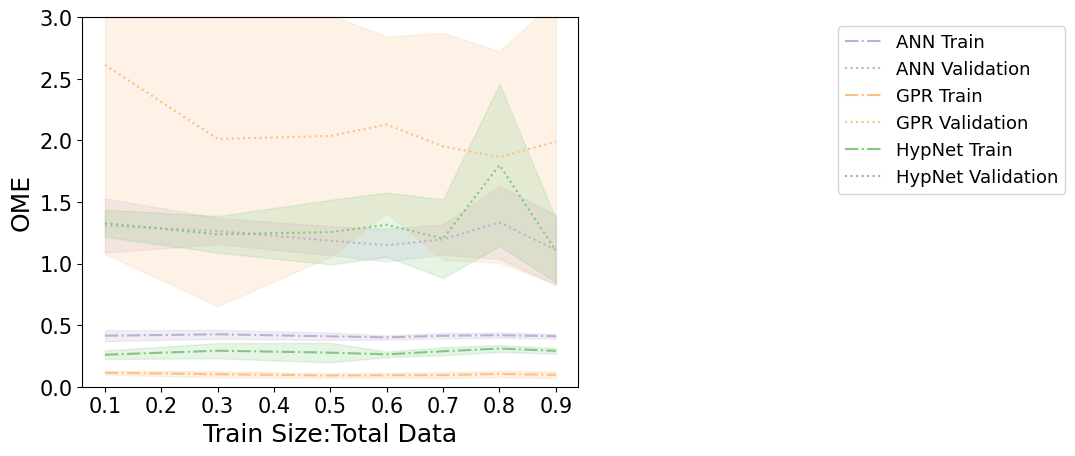

In [35]:
LC_viz2(ANN_OME, GPR_OME, HypNet_OME)
#LC_viz(ANN_R2, GPR_R2, HypNet_R2)

In [16]:
GPR_OME

{'test': {'avg': [nan, nan, 1.8378937, nan, 1.1615819],
  'std': [nan, nan, 0.0, nan, 0.0]},
 'train': {'avg': [nan, nan, 0.07232035, 0.11619717, 0.09010449],
  'std': [nan, nan, 0.0, 0.019067619, 0.0]}}

old

In [ ]:
#for each split
    ##Get data from file
    #preprocess and scale
    #make predictions like parity -- but only keep errors
    #save errors
data = ''
GPR_OME = {'test':{'avg':[], 'std': []}, 'train':{'avg':[], 'std': []}}
ANN_OME = {'test':{'avg':[], 'std': []}, 'train':{'avg':[], 'std': []}}

models_list = os.listdir('./MODELS')
for test_size in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    #Load Data
    GPR_err = {'test': [], 'train':[]}
    ANN_err = {'test':[], 'train':[]}
    for mod_num in [0,1,2,3,4]:
        for a in ['_', '_aug']:
            try:
                test_type = [m for m in models_list if f'LC{mod_num}{a}' in m and f'{test_size}' in m][0]
                print(test_type)
            except:
                print(f'LC{mod_num}{a} not found.')
                continue
            try:
                train_df = pd.read_pickle(f'MODELS/{test_type}/train_data.pkl')
                test_df = pd.read_pickle(f'MODELS/{test_type}/test_data.pkl')
            except:
                print(f'Did not find {test_type}')
                continue
            #Preprocess, scale
            fp_cols = []
            for c in train_df.columns:
                if isinstance(c, str):
                    if 'fp' in c:
                        fp_cols.append(c)

            logMw = np.array(train_df['Mw']).reshape((-1,1))
            shear = np.array(train_df['Shear_Rate']).reshape((-1,1))
            Temp = np.array(train_df['Temperature']).reshape((-1,1))
            Temp = 1/(Temp+273.15)
            PDI = np.array(train_df['PDI']).reshape((-1,1))

            scaler = MinMaxScaler(copy = False)
            XX = np.array(scaler.fit(train_df.filter(fp_cols)).transform(train_df.filter(fp_cols)))
            yy = np.array(train_df.loc[:,'Melt_Viscosity']).reshape((-1,1))

            y_scaler = MinMaxScaler().fit(yy)
            yy = y_scaler.transform(yy);
            T_scaler = MinMaxScaler().fit(Temp)
            T = T_scaler.transform(Temp);
            M_scaler = MinMaxScaler().fit(logMw)
            M = M_scaler.transform(logMw);
            S_trans = PowerTransformer(standardize = False).fit(shear)
            S_scaler = MinMaxScaler().fit(S_trans.transform(shear))
            S = S_scaler.transform(S_trans.transform(shear))
            P_scaler = MinMaxScaler().fit(PDI)
            P = P_scaler.transform(PDI)
            #shear = S_scaler.transform((shear))
            #gpr_Mcr, mcr_cv_error = Mcr_gpr_train(OG_fp, None, M_scaler, scaler, transform = False)
            
            y_test = y_scaler.transform(np.array(test_df.loc[:,'Melt_Viscosity']).reshape((-1,1)))
            X_test = np.array(scaler.transform(test_df.filter(fp_cols)))
            M_test = M_scaler.transform(np.array(test_df['Mw']).reshape((-1,1)))
            S_test = S_scaler.transform(S_trans.transform(np.array(test_df['Shear_Rate']).reshape((-1,1))))
            T_test = np.array(test_df['Temperature']).reshape((-1,1))
            T_test = T_scaler.transform(1/(T_test+273.15))
            P_test = P_scaler.transform(np.array(test_df['PDI']).reshape((-1,1)))

            #Load Models
            try:
                models, history, gpr_models, gp_cv, NN_cv = load_models(date = test_type[:10], data_type = test_type[11:], NN_models = [create_ViscNN_concat])
                model_reloaded = True
            except:
                print(f'Did not find model {test_type}')
                continue
            #Predict
            yy = y_scaler.inverse_transform(yy)
            y_test = y_scaler.inverse_transform(y_test)
            test_pred, test_var,_ = predict_all_cv(models[0],[X_test, M_test, S_test, T_test, P_test])
            train_pred, train_var,_ = predict_all_cv(models[0],[XX, M, S, T, P])
            test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1))
            train_pred = y_scaler.inverse_transform(np.array(train_pred).reshape(-1, 1))
            ANN_err['test'].append(OME(y_test, test_pred))
            ANN_err['train'].append(OME(yy, train_pred))

            gpr_model = gpr_models[5] 
            X_ = np.concatenate((X_test, M_test, S_test, T_test, P_test), axis = 1)
            X_train = np.concatenate((XX, M, S, T, P), axis = 1)
            test_pred, var = gpr_model.predict_f_compiled(tf.convert_to_tensor(X_, dtype=tf.float64))
            train_pred, var_train = gpr_model.predict_f_compiled(X_train)
            test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1))
            train_pred = y_scaler.inverse_transform(np.array(train_pred).reshape(-1, 1))
            GPR_err['train'].append(OME(yy, train_pred))
            GPR_err['test'].append(OME(y_test, test_pred))
    GPR_OME['test']['avg'].append(np.mean(GPR_err['test']))
    GPR_OME['test']['std'].append(np.std(GPR_err['test']))
    GPR_OME['train']['avg'].append(np.mean(GPR_err['train']))
    GPR_OME['train']['std'].append(np.std(GPR_err['train']))
    ANN_OME['test']['avg'].append(np.mean(ANN_err['test']))
    ANN_OME['test']['std'].append(np.std(ANN_err['test']))
    ANN_OME['train']['avg'].append(np.mean(ANN_err['train']))
    ANN_OME['train']['std'].append(np.std(ANN_err['train']))


2022-11-24_LC0_aug_split_test_0.9_full
Did not find model 2022-11-24_LC0_aug_split_test_0.9_full
2022-11-24_LC0_aug_split_test_0.9_full
Did not find model 2022-11-24_LC0_aug_split_test_0.9_full
2022-11-25_LC1_aug_split_test_0.9_full
Did not find model 2022-11-25_LC1_aug_split_test_0.9_full
2022-11-25_LC1_aug_split_test_0.9_full
Did not find model 2022-11-25_LC1_aug_split_test_0.9_full
LC2_ not found.
LC2_aug not found.
2023-01-04_LC3_polysplit_0.9
Did not find model 2023-01-04_LC3_polysplit_0.9
LC3_aug not found.
2023-01-04_LC4_polysplit_0.9
